# Euclidean latent space model for Networks: Model $\mathbb{R}^3$

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.EuclideanC import *

## Network

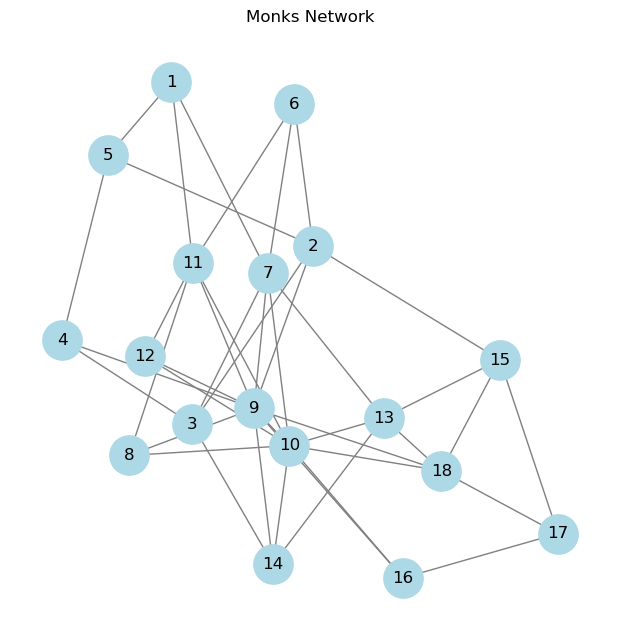

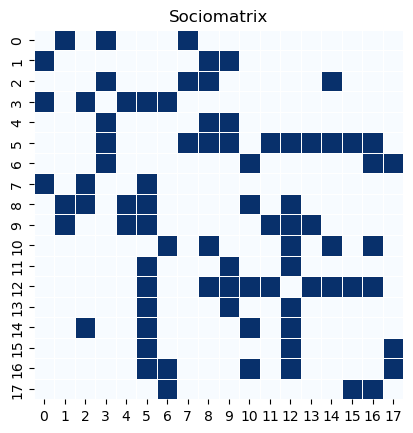

In [3]:
import zipfile
from io import BytesIO as StringIO

with zipfile.ZipFile("sampson_data.zip") as zf:
    g = StringIO(zf.read("samplike1.txt"))

G = nx.read_edgelist(g, delimiter="\t")
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Monks Network")
plt.show()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -244.04155239941736
Final log-likelihood: -30.579925642936036
Final alpha: 22.042131260965988


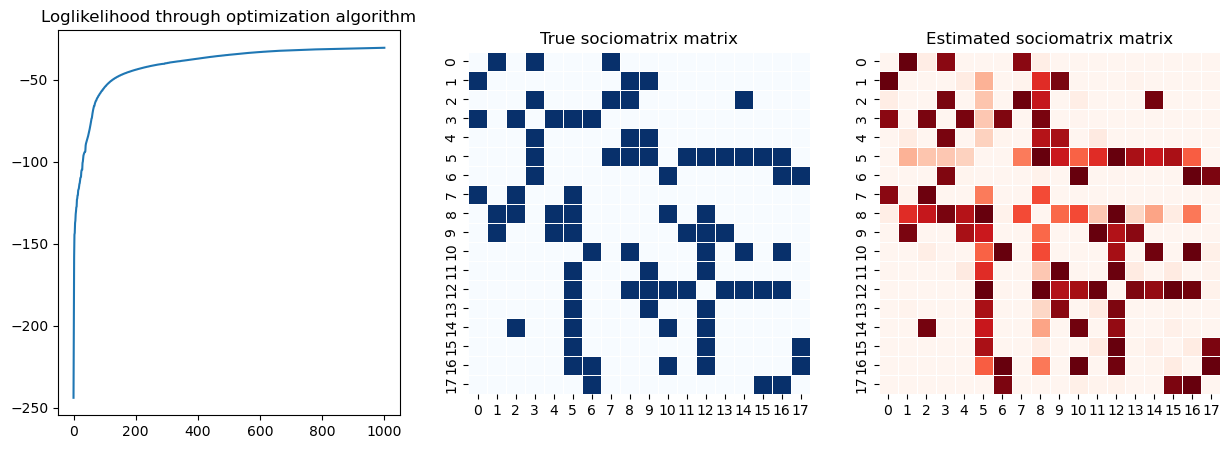

In [4]:

Z_init = np.random.randn(n, 3)
a_init = np.random.randn()

Z_ML, a_ML, historyZ, historya =  SearchingMLE(G, Z_init ,a_init,1000)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)


df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = list(G.nodes)
fig = px.scatter_3d(df, x='x', y='y', z='z', text='node', opacity=0.9)
fig.update_layout(title='Maximum likelihood estimation of latent positions')
fig.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(1,3,2)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,3,3)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [13]:
# Execute HMC
number_of_samples = 500
Z_init = Z_init
a_init = np.float64(a_init)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init))

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, 
                                                         epsilon_init=0.015, std_dev_Z=0.25,  std_dev_a=1.0,
                                                         percentage_warmup=0.05, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -30.579925642936036
Log-L starter: -30.579925642936036
Number of samples: 500
Number of parameters: 19
Number of iterations: 525
Number of warmup iterations: 25


  5%|▍         | 25/525 [00:33<11:28,  1.38s/it]

Final parameters: epsilon=0.0133, L=75, std_dev_Z=0.2217, std_dev_a=1.0000


100%|██████████| 525/525 [13:42<00:00,  1.57s/it]

Acceptance rate: 0.54366
Log-L MAP: -107.31947881820763
Log-L CM: -85.27465938011233


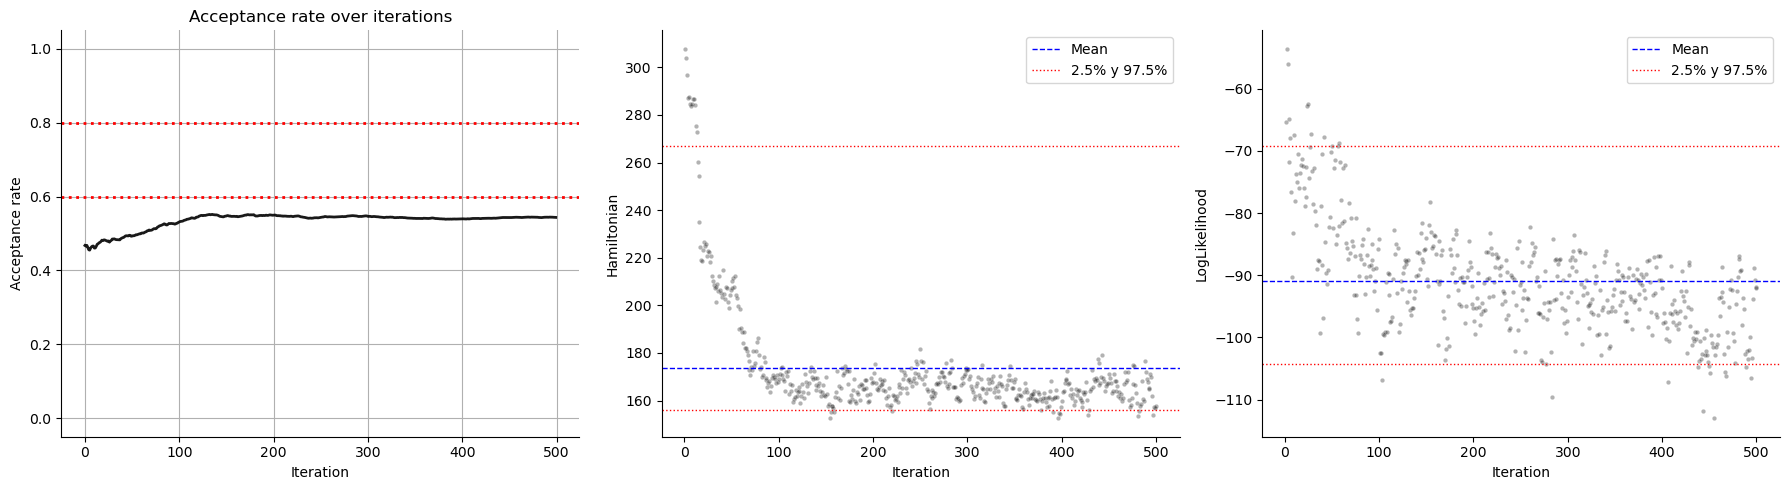

In [14]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [15]:
plot_Z_samples_3D(samples_Z[-100:])

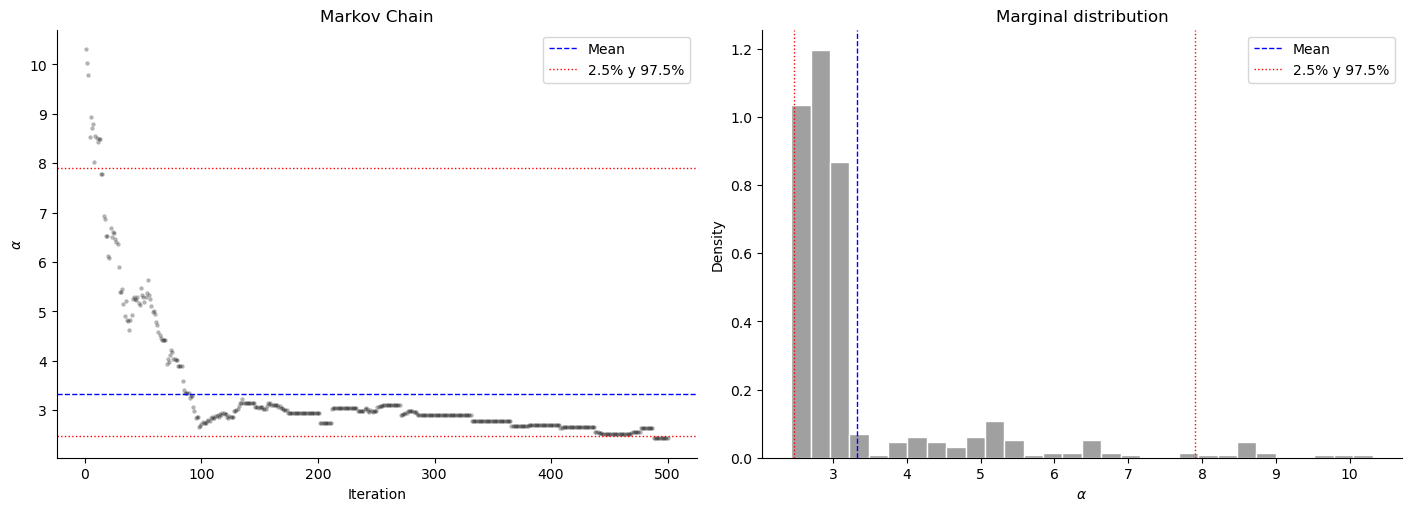

In [16]:
plot_alpha(samples_a)

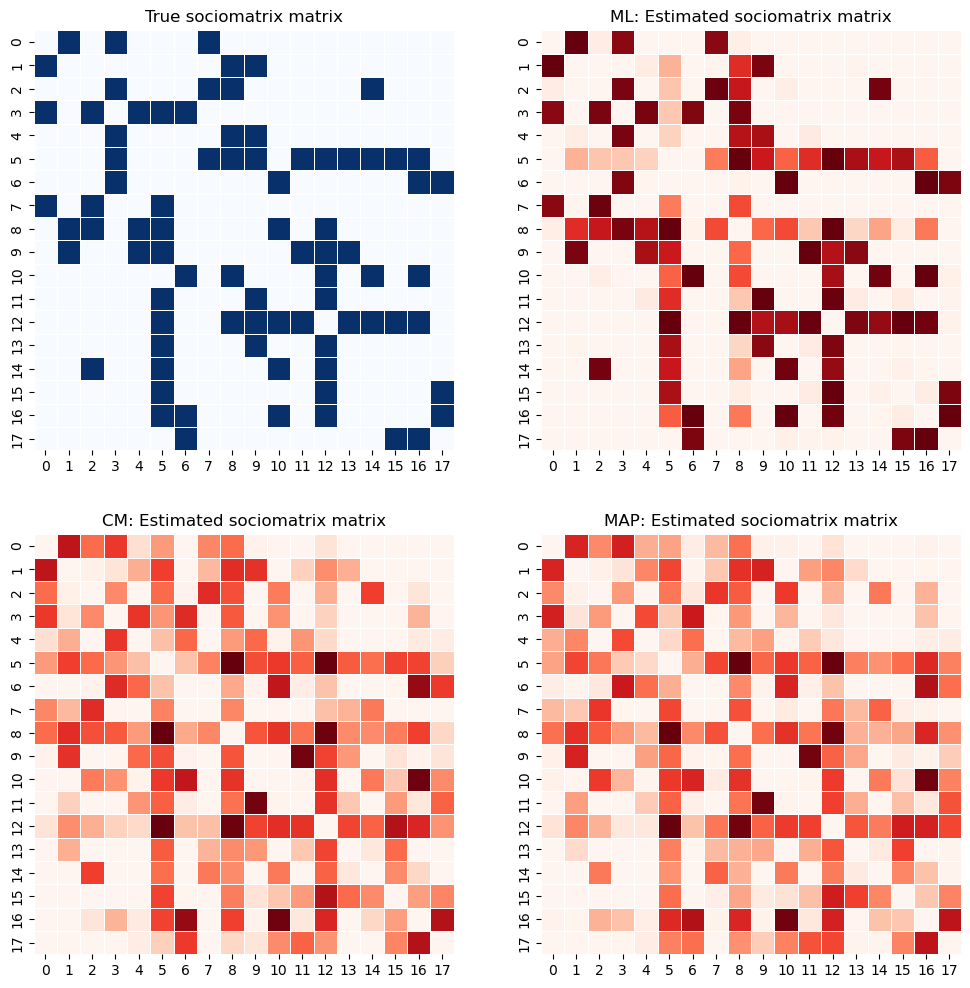

In [12]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [13]:
clustering3D(G,node_mapping, Z_ML, a_ML, Z_MAP, a_MAP, Z_CM, a_CM)

[[0, 1, 3, 4], [5, 8, 12, 15], [9, 11, 13], [6, 16, 17], [10, 14], [2, 7]]

### Model Evaluation

#### Posterior predictive checking

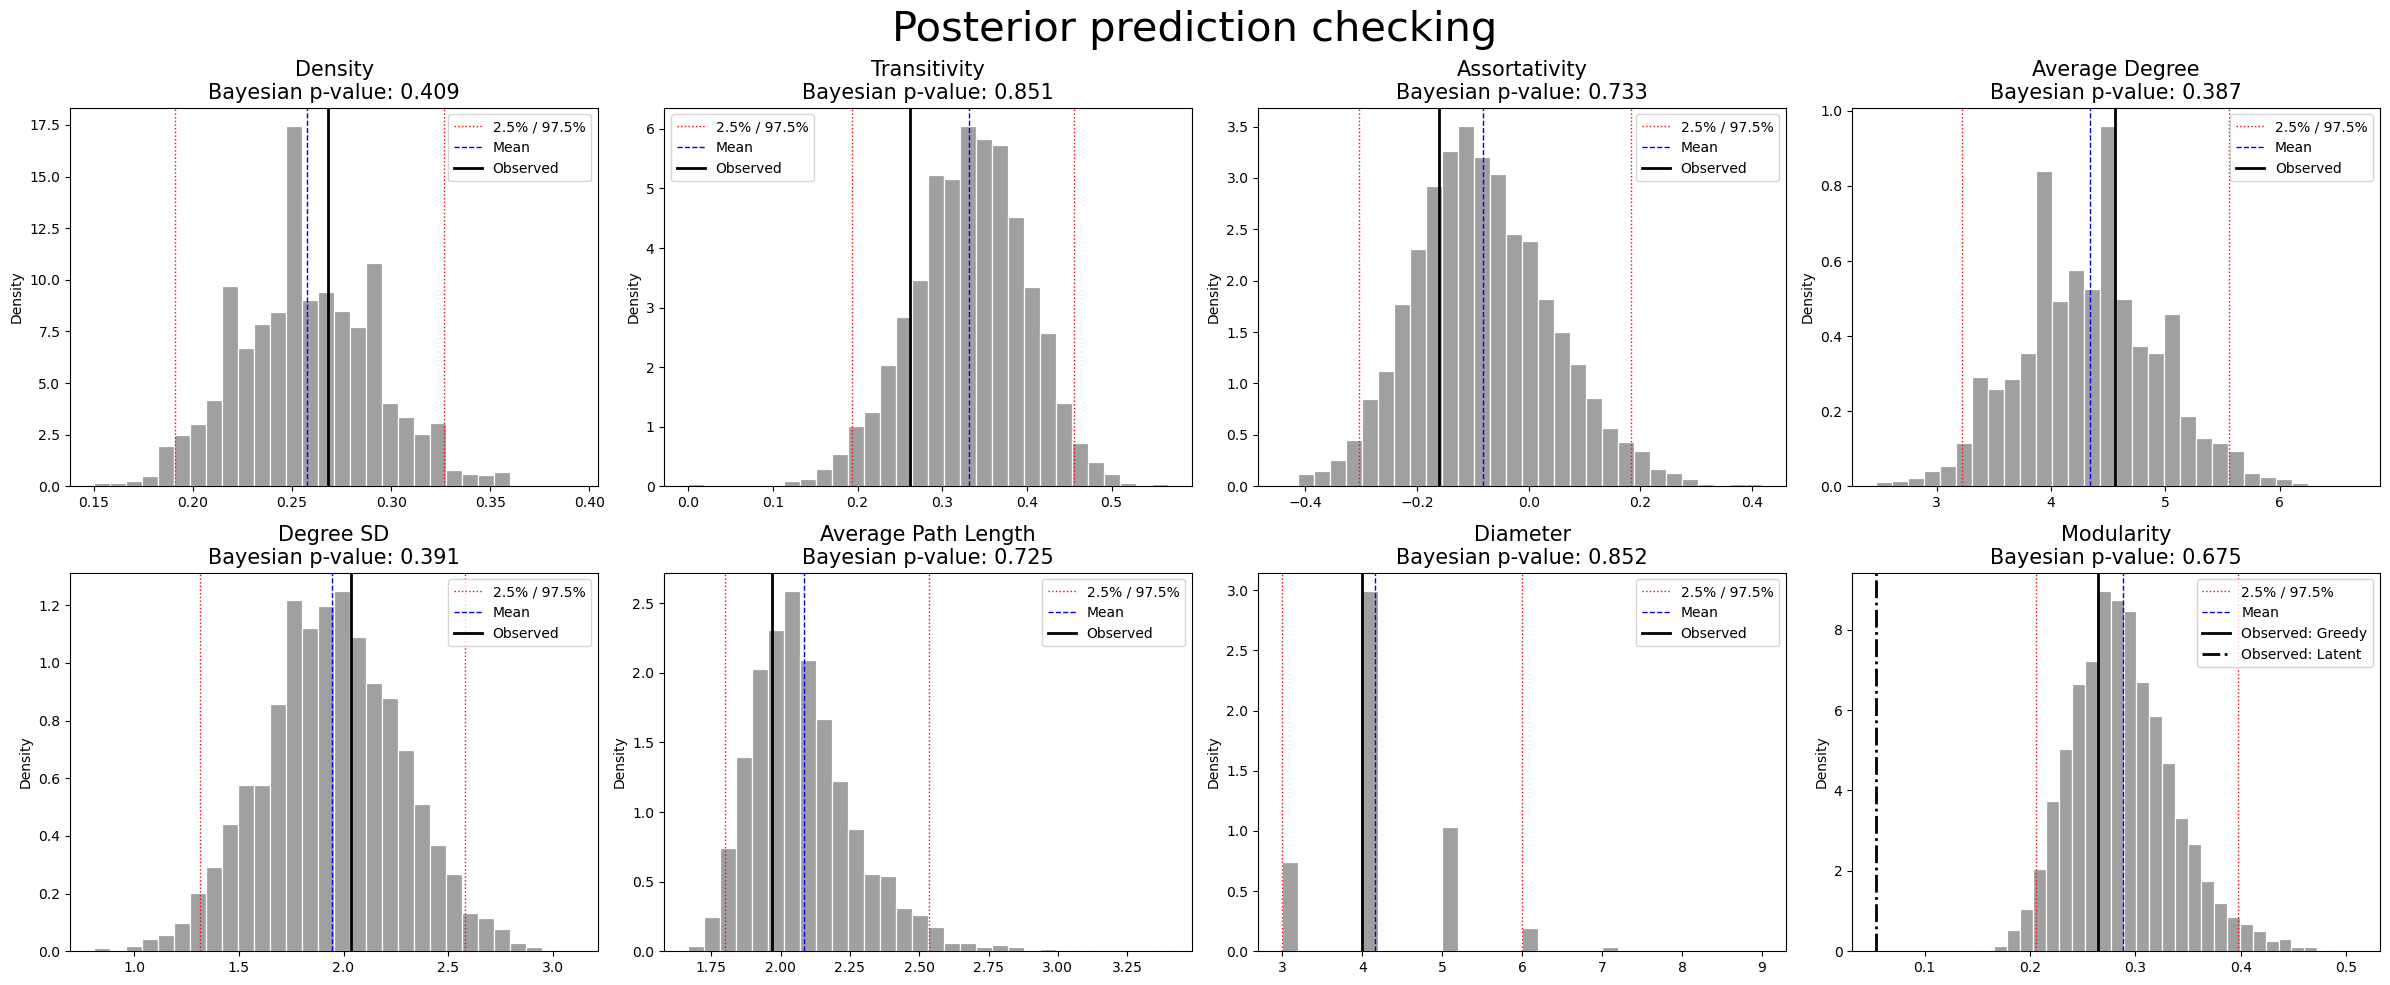

In [14]:
predictive_check(G,samples_Z,samples_a)

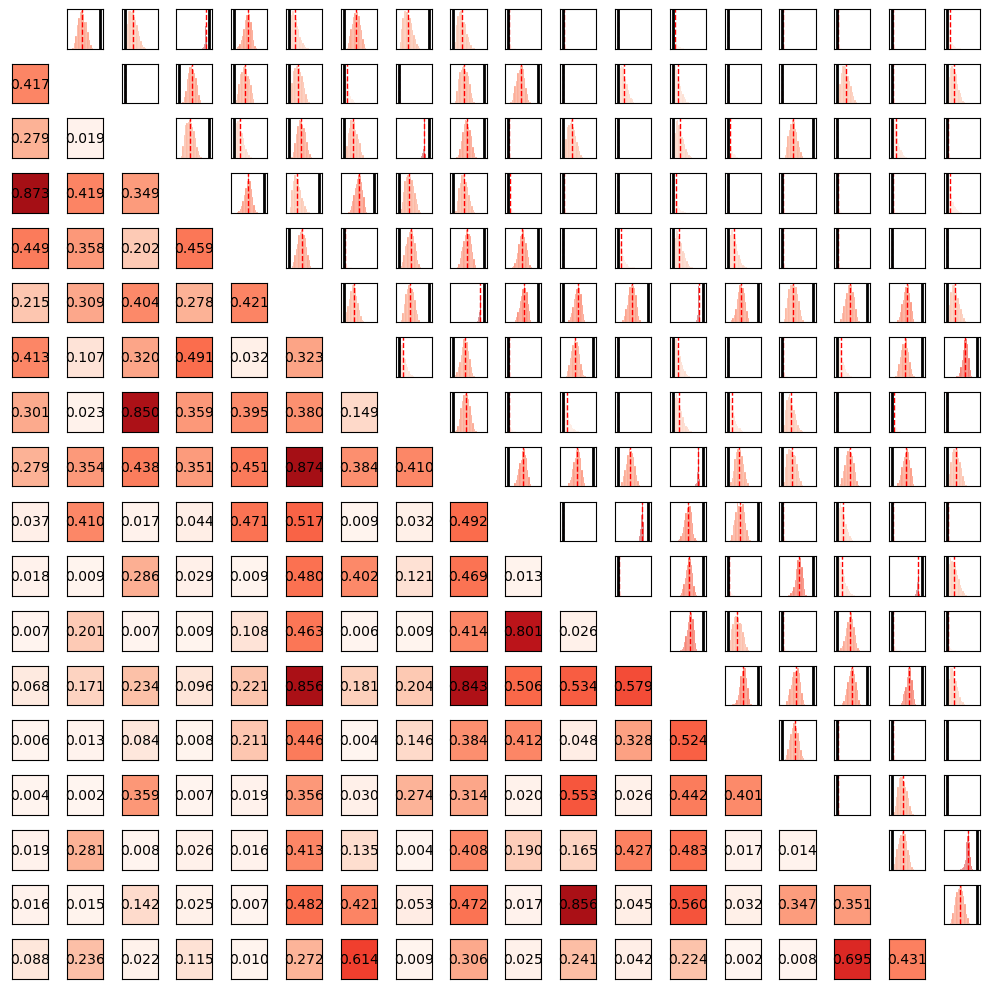

In [15]:
plot_pairwise_sociomatrix(G,samples_Z,samples_a,Y)

#### Model comparison criteria

In [16]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 220.1522
DIC: 224.1898


#### Prior predictive checking

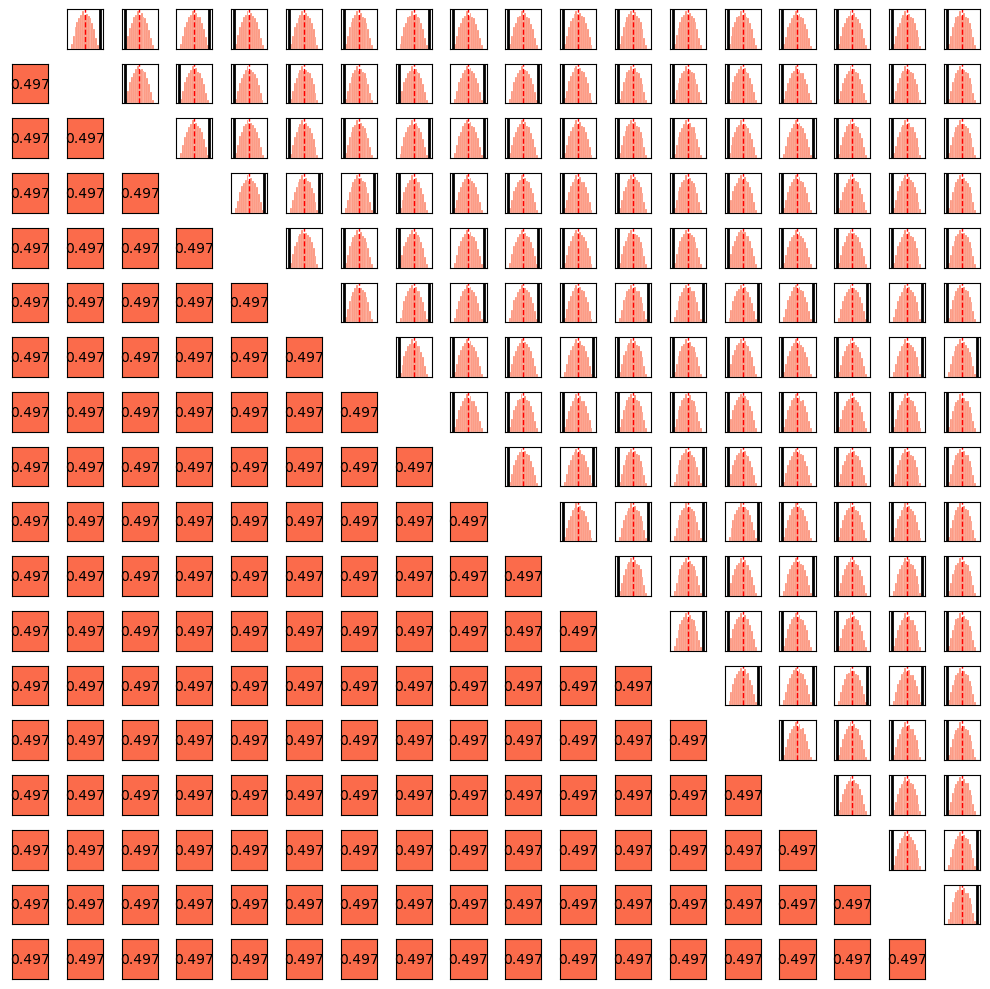

In [17]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior,samples_a_prior,Y)

#### Prediction evaluation

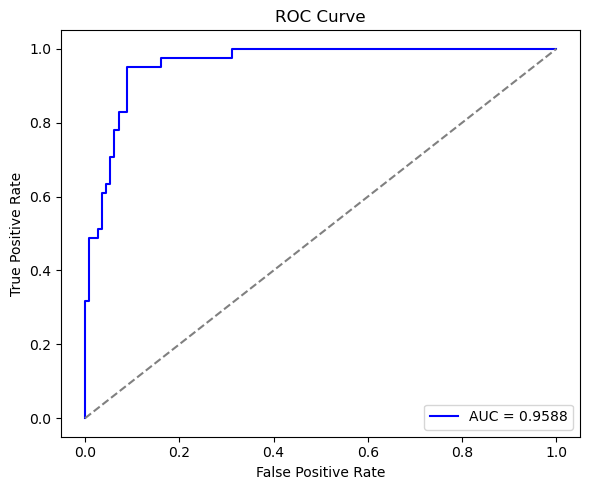

{'roc_auc': 0.9588414634146342,
 'confusion_matrix': {'tp': 22, 'tn': 108, 'fp': 4, 'fn': 19},
 'accuracy': 0.8496732026143791,
 'precision': 0.8461538461538461,
 'recall': 0.5365853658536586,
 'f1_score': 0.6567164179104478,
 'specificity': 0.9642857142857143}

In [8]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a))

## References

[1]